**Obesity Dataset**

Obesity is an imbalanced dataset with 16 features out of which 3 are continuous, while 13 are categorical.

We use boxplots to visualize the distribution of continuous data. All the categorical data is then processed through one-hot encoding. Continuous data is processed by recalculation of outliers and then scaled to a range of 0 to 1.

Next, we perform feature selection on the dataset using different feature selection methods including RFE, Mutual Information, Variance Thresholding, and PCA. The best average of the results is obtained using PCA with 3 components.

After this, cross validation is performed for each of the procedures, where the number of splits is set to 5. The best performing parameters for each of the algorithms are found through GridSearchCV.

### **Preprocessing Functions**

In [2]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold, mutual_info_regression, RFE
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC, OneClassSVM
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.tree import DecisionTreeClassifier
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
from google.colab import files
from sklearn.metrics.pairwise import euclidean_distances

In [3]:
def feature_selection(df, headers, target, method, n):

  # separating target from the data
  X=df[headers]
  y=df[target]

  # correlation heatmap
  #plt.figure(figsize = (25, 25))
  #sns.heatmap(df.corr(), annot = True, cmap='coolwarm', fmt='.2f')
  #print("\n")

  if ((method == 'chi2') | (method == 'mutualinfo')):
    features = fs_chi_mutual(X, y, n, method)

  elif (method == 'varthresh'):
    features = fs_varthresh(X, y, n)

  elif (method == 'rfe'):
    features = fs_rfe(X, y, n)

  elif (method == 'pca'):
    features = fs_pca(X, y, n)
  else:
    print("Wrong input method")
    return

  print('\n')
  return features


In [4]:
def fs_chi_mutual(X, y, k, method):

  # Feature extraction
  if (method == 'chi2'):
    selector = SelectKBest(chi2, k=k)
    print("Selected features using Chi2 method are:")
  elif (method == 'mutualinfo'):
    selector = SelectKBest(mutual_info_regression, k=k)
    print("Selected features using Mutual Information method are:")

  fit = selector.fit_transform(X, y)

  # Get the indices of the selected features
  indices = selector.get_support(indices=True)

  # Get the column names of the selected features
  feature_names = X.columns[indices].tolist()
  print(feature_names)
  return fit

In [5]:
def fs_varthresh(X, y, thresh):

  # Feature extraction using variance threshold
  var_thresh = VarianceThreshold(threshold = thresh)
  var_thresh.fit(X)
  indices = var_thresh.get_support(indices = True)

  # Get the column names of the selected features
  feature_names = X.columns[indices].tolist()
  print("Selected features using Variance Thresholding filter method are:")
  print(feature_names)
  return X[feature_names]


In [6]:
def fs_rfe(X, y, k):

  # applying RFE using linear regression
  estimator = LinearRegression()
  selector = RFE(estimator, n_features_to_select=k, importance_getter='auto')
  fit = selector.fit_transform(X, y)

  # Get the indices of the selected features
  indices = selector.get_support(indices=True)

  # Get the column names of the selected features
  feature_names = X.columns[indices].tolist()

  print("Selected features using Recursive Feature Elimination wrapper method are:")
  print(feature_names)
  return fit


In [7]:
def fs_pca(X, y, n):
# function for Principal Component Analysis

  pca = PCA(n_components = n)
  features = pca.fit_transform(X)

  return features


In [8]:
def cat_visualization(df, args):
# function to visualize of categorical data

    fig, axes = plt.subplots(7, 5, figsize=(25, 25))
    axes = axes.ravel()
    for i, arg in enumerate(args[:-1]):
        sns.countplot(data=df, x=arg, hue=args[-1], ax=axes[i])
    plt.tight_layout(w_pad=1)
    plt.suptitle('Data Distributions of Categorical Features against Target values', fontsize=20, y=1.02)
    plt.show()

In [9]:
def cont_visualization(df, int_cols):
# function to visualize continuous data

  # histogram of all continuous features
  fig, axs = plt.subplots(6, 5, figsize=(12,15))
  for f, ax in zip(int_cols, axs.ravel()):
      mi = df[f].min()
      ma = df[f].max()
      bins = np.linspace(mi, ma, 30)
      ax.hist(df[f], bins=bins, alpha=0.6)
      ax.set_xlabel(f)

  plt.tight_layout(w_pad=1)
  plt.suptitle('Data Distribution of Numerical Features', fontsize=20, y=1.02)
  plt.show()

In [10]:
def exploratory_analysis(df, continuous, target):

  print("5 Number Summary:")
  print(df.describe())
  print("\n")

  cont_visualization(df, continuous)
  print("\n")


In [11]:
def data_preprocessing():
  path='/content/Dataset 3 - Obesity.csv'
  df = pd.read_csv(path)
  headers = df.columns.tolist()
  target = 'NObeyesdad'
  attributes = [x for x in headers if x!=target]
  continuous = ['Age', 'Height', 'Weight']
  categorical = [x for x in attributes if x not in continuous]

  # boxplots of continuous data to visualize data distribution
  print("\n Boxplots of Continuous Data before Pre-Processing:")
  fig, axs = plt.subplots(1, 3, figsize=(12, 3))
  for i, header in enumerate(continuous):
    axs = axs.ravel()
    sns.boxplot(x=df[header], ax=axs[i])
    axs[i].set_title(header)
  plt.tight_layout()
  plt.show()

  # one-hot encoding of categorical data
  df = pd.get_dummies(df, columns=categorical)

  headers = df.columns.tolist()
  attributes = [x for x in headers if x!=target]
  continuous = ['Age', 'Height', 'Weight']
  categorical = [x for x in attributes if x not in continuous]

  # label encoding of "Target"
  df[target]=df[target].map({'Not Obese':1, 'Obese':0})

  # fixing outliers to replace them with minimum or maximum allowed values
  for header in continuous:
    Q1 = df[header].quantile(0.25)
    Q3 = df[header].quantile(0.75)
    IQR = Q3 - Q1
    #replacing outliers with Minimum and Maximum values
    df[header]=np.where(df[header] < (Q1 - (1.5*IQR)), Q1 - 1.5 * IQR, np.where(df[header] > (Q3 + (1.5*IQR)), Q3 + (1.5*IQR), df[header]))
  df.fillna(0, inplace=True)

  # boxplots of continuous data to visualize data distribution
  print("\n Boxplots of Continuous Data after Fixing Outliers:")
  fig, axs = plt.subplots(1, 3, figsize=(12, 3))
  for i, header in enumerate(continuous):
    axs = axs.ravel()
    sns.boxplot(x=df[header], ax=axs[i])
    axs[i].set_title(header)
  plt.tight_layout()
  plt.show()

  return df, continuous, categorical, target


In [12]:
def data_processing(df, continuous, categorical, target):

  # scaling continuous data such that all columns are in the range 0 to 1
  scaler = MinMaxScaler()
  df[continuous] = scaler.fit_transform(df[continuous]) #Scaling and normalizing numerical data

  # performing Feature Selection using Chi2
  selected_df = feature_selection(df, continuous+categorical, target, 'pca', 3)

  # separating target from the data
  X = selected_df
  y = df[target]

  return X, y


In [13]:
def split_data(X, y):

  # splitting data into training and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)

  print("The dimension of X_train is {}".format(X_train.shape))
  print("The dimension of X_test is {}".format(X_test.shape))

  return X_train, X_test, y_train, y_test

## **Baseline Analysis**

In [ ]:
def baseline_model(splits, estimator, param_grid):

  X_train, X_test, y_train, y_test = splits

  # Create GridSearchCV object with stratified cross-validation
  stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=39)
  grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=stratified_cv, scoring='accuracy')

  # Fit GridSearchCV to training data after scaling
  grid_search.fit(X_train, y_train)

  best_params = grid_search.best_params_
  print("\nBest Parameters:", best_params)
  print("\n")
  # Access best model and hyperparameters
  best_model = grid_search.best_estimator_

  train_score = best_model.score(X_train,y_train)
  test_score = best_model.score(X_test,y_test)

  print("The train score for the best KNN model is {}".format(train_score))
  print("The test score for the best KNN model is {}\n".format(test_score))

  y_pred = best_model.predict(X_test)

  return y_pred

In [ ]:
def baseline_main():

  df, continuous, categorical, target = data_preprocessing()
  X, y = data_processing(df, continuous, categorical, target)
  X_train, X_test, y_train, y_test = split_data(X, y)

  splits = [X_train, X_test, y_train, y_test]



  # KNN CLASSIFIER
  print("\n\n\n -------------------- KNN CLASSIFIER --------------------")
  knn_estimator = KNeighborsClassifier()
  knn_param_grid = {'n_neighbors': [x for x in range(1,21)]}
  y_pred_knn = baseline_model(splits, knn_estimator, knn_param_grid)

  print("Classification Report Using KNN:")
  print(classification_report(y_test, y_pred_knn))

  cm = confusion_matrix(y_test, y_pred_knn)
  print("Confusion Matrix:\n", cm)



  # SUPPORT VECTOR MACHINE
  print("\n\n\n -------------------- SUPPORT VECTOR MACHINE --------------------")
  svm_estimator = SVC()
  svm_param_grid = {'C': [0.1, 0.5, 1, 5, 10, 15], 'kernel': ['linear', 'rbf', 'poly'], 'gamma': ['scale', 'auto']}
  y_pred_svm = baseline_model(splits, svm_estimator, svm_param_grid)

  print("Classification Report Using SVM:")
  print(classification_report(y_test, y_pred_svm))

  cm = confusion_matrix(y_test, y_pred_svm)
  print("Confusion Matrix:\n", cm)



  # LOGISTIC REGRESSION
  print("\n\n\n -------------------- LOGISTIC REGRESSION --------------------")
  log_estimator = LogisticRegression()
  log_param_grid = {'C': [0.1, 0.5, 1, 5, 10, 15], 'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'saga']}
  y_pred_log = baseline_model(splits, log_estimator, log_param_grid)

  print("Classification Report Using Logistic Regression:")
  print(classification_report(y_test, y_pred_log))

  cm = confusion_matrix(y_test, y_pred_log)
  print("Confusion Matrix:\n", cm)



  # DECISION TREE CLASSIFIER
  print("\n\n\n -------------------- DECISION TREE CLASSIFIER --------------------")
  tree_estimator = DecisionTreeClassifier()
  tree_param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10]}
  y_pred_tree = baseline_model(splits, tree_estimator, tree_param_grid)

  print("Classification Report Using Decision Tree Classifier:")
  print(classification_report(y_test, y_pred_tree))

  cm = confusion_matrix(y_test, y_pred_tree)
  print("Confusion Matrix:\n", cm)



  # RANDOM FORREST CLASSIFIER
  print("\n\n -------------------- RANDOM FOREST CLASSIFIER --------------------")
  for_estimator = RandomForestClassifier()
  for_param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10]}
  y_pred_for = baseline_model(splits, for_estimator, for_param_grid)

  print("Classification Report Using Random Forest Classifier:")
  print(classification_report(y_test, y_pred_for))

  cm = confusion_matrix(y_test, y_pred_for)
  print("Confusion Matrix:\n", cm)


 Boxplots of Continuous Data before Pre-Processing:


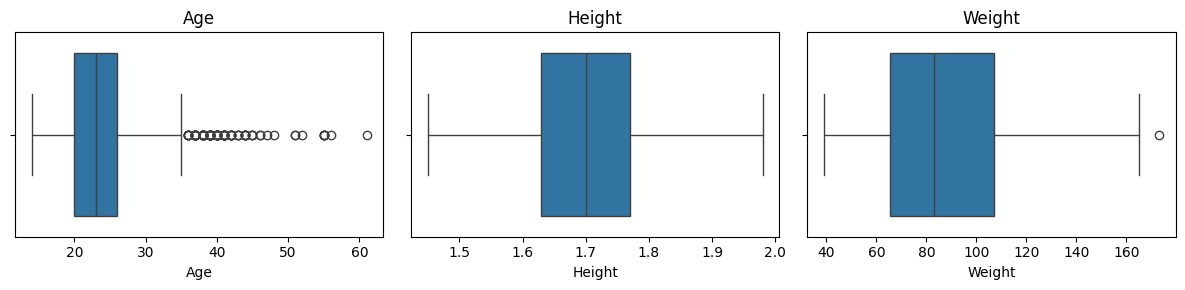


 Boxplots of Continuous Data after Fixing Outliers:


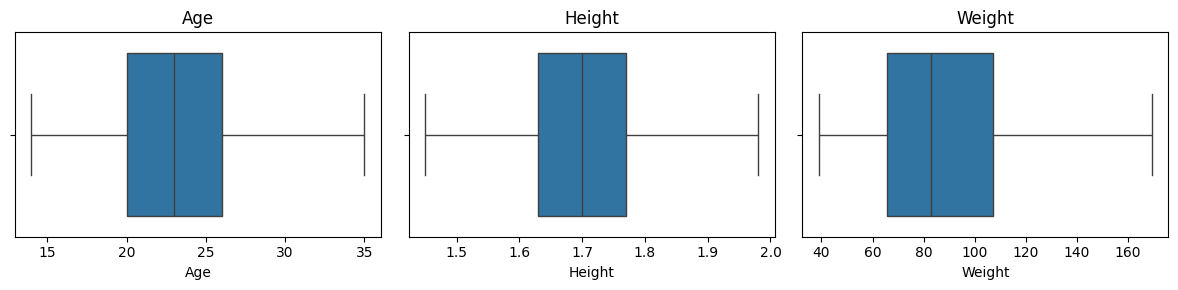



The dimension of X_train is (1477, 3)
The dimension of X_test is (634, 3)



 -------------------- KNN CLASSIFIER --------------------

Best Parameters: {'n_neighbors': 2}


The train score for the best KNN model is 0.9085985104942451
The test score for the best KNN model is 0.8091482649842271

Classification Report Using KNN:
              precision    recall  f1-score   support

           0       0.83      0.95      0.88       477
           1       0.70      0.39      0.51       157

    accuracy                           0.81       634
   macro avg       0.77      0.67      0.69       634
weighted avg       0.80      0.81      0.79       634

Confusion Matrix:
 [[451  26]
 [ 95  62]]



 -------------------- SUPPORT VECTOR MACHINE --------------------

Best Parameters: {'C': 15, 'gamma': 'scale', 'kernel': 'rbf'}


The train score for the best KNN model is 0.8104265402843602
The test score for the best KNN model is 0.8296529968454258

Classification Report Using SVM:
           

In [ ]:
baseline_main()

## **Analysis with CI Solutions**

### SMOTE

In [14]:
def smote_balancing(df, attributes, target):

  print("Class Distribution before SMOTE:")
  print(df[target].value_counts())

  # Apply SMOTE to balance the dataset
  smote = SMOTE(random_state=42)
  X_resampled, y_resampled = smote.fit_resample(df[attributes], df[target])

  # Convert resampled data back to DataFrame
  df_resampled = pd.concat([X_resampled, y_resampled], axis=1)

  # Check class distribution after SMOTE
  print("\nClass Distribution after SMOTE:")
  print(df_resampled[target].value_counts())

  file_path = '/content/Dataset 3 - Obesity - SMOTE Balanced.csv'

  # Save the DataFrame to a CSV file
  df_resampled.to_csv(file_path, index=False)
  files.download('Dataset 3 - Obesity - SMOTE Balanced.csv')

  return df_resampled

In [15]:
def smote_model(splits, estimator, param_grid):

  X_train, X_test, y_train, y_test = splits

  # Create GridSearchCV object with stratified cross-validation
  stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=39)
  grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=stratified_cv, scoring='accuracy')

  # Fit GridSearchCV to training data after scaling
  grid_search.fit(X_train, y_train)

  best_params = grid_search.best_params_
  print("\nBest Parameters:", best_params)
  print("\n")
  # Access best model and hyperparameters
  best_model = grid_search.best_estimator_

  train_score = best_model.score(X_train,y_train)
  test_score = best_model.score(X_test,y_test)

  print("The train score for the best KNN model is {}".format(train_score))
  print("The test score for the best KNN model is {}\n".format(test_score))

  y_pred = best_model.predict(X_test)

  return y_pred

In [16]:
def smote_main():
  df, continuous, categorical, target = data_preprocessing()
  df_resampled = smote_balancing(df, continuous+categorical, target)
  X, y = data_processing(df_resampled, continuous, categorical, target)
  X_train, X_test, y_train, y_test = split_data(X, y)

  splits = [X_train, X_test, y_train, y_test]



  # KNN CLASSIFIER
  print("\n\n\n -------------------- KNN CLASSIFIER --------------------")
  knn_estimator = KNeighborsClassifier()
  knn_param_grid = {'n_neighbors': [x for x in range(1,21)]}
  y_pred_knn = smote_model(splits, knn_estimator, knn_param_grid)

  print("Classification Report Using KNN:")
  print(classification_report(y_test, y_pred_knn))

  cm = confusion_matrix(y_test, y_pred_knn)
  print("Confusion Matrix:\n", cm)



  # SUPPORT VECTOR MACHINE
  print("\n\n\n -------------------- SUPPORT VECTOR MACHINE --------------------")
  svm_estimator = SVC()
  svm_param_grid = {'C': [0.1, 0.5, 1, 5, 10, 15], 'kernel': ['linear', 'rbf', 'poly'], 'gamma': ['scale', 'auto']}
  y_pred_svm = smote_model(splits, svm_estimator, svm_param_grid)

  print("Classification Report Using SVM:")
  print(classification_report(y_test, y_pred_svm))

  cm = confusion_matrix(y_test, y_pred_svm)
  print("Confusion Matrix:\n", cm)



  # LOGISTIC REGRESSION
  print("\n\n\n -------------------- LOGISTIC REGRESSION --------------------")
  log_estimator = LogisticRegression()
  log_param_grid = {'C': [0.1, 0.5, 1, 5, 10, 15], 'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'saga']}
  y_pred_log = smote_model(splits, log_estimator, log_param_grid)

  print("Classification Report Using Logistic Regression:")
  print(classification_report(y_test, y_pred_log))

  cm = confusion_matrix(y_test, y_pred_log)
  print("Confusion Matrix:\n", cm)



  # DECISION TREE CLASSIFIER
  print("\n\n\n -------------------- DECISION TREE CLASSIFIER --------------------")
  tree_estimator = DecisionTreeClassifier()
  tree_param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10]}
  y_pred_tree = smote_model(splits, tree_estimator, tree_param_grid)

  print("Classification Report Using Decision Tree Classifier:")
  print(classification_report(y_test, y_pred_tree))

  cm = confusion_matrix(y_test, y_pred_tree)
  print("Confusion Matrix:\n", cm)



  # RANDOM FORREST CLASSIFIER
  print("\n\n -------------------- RANDOM FOREST CLASSIFIER --------------------")
  for_estimator = RandomForestClassifier()
  for_param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10]}
  y_pred_for = smote_model(splits, for_estimator, for_param_grid)

  print("Classification Report Using Random Forest Classifier:")
  print(classification_report(y_test, y_pred_for))

  cm = confusion_matrix(y_test, y_pred_for)
  print("Confusion Matrix:\n", cm)


 Boxplots of Continuous Data before Pre-Processing:


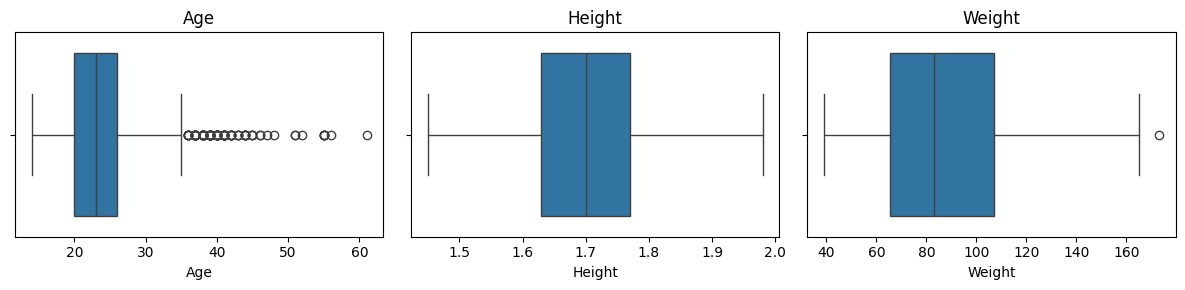


 Boxplots of Continuous Data after Fixing Outliers:


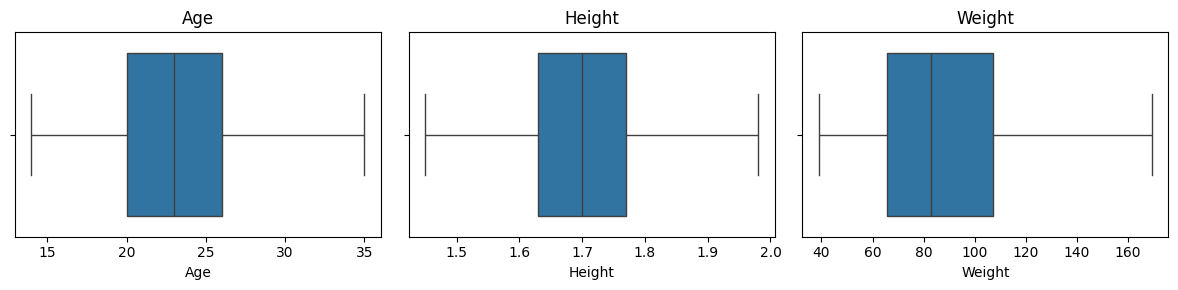

Class Distribution before SMOTE:
NObeyesdad
0    1552
1     559
Name: count, dtype: int64

Class Distribution after SMOTE:
NObeyesdad
1    1552
0    1552
Name: count, dtype: int64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



The dimension of X_train is (2172, 3)
The dimension of X_test is (932, 3)



 -------------------- KNN CLASSIFIER --------------------

Best Parameters: {'n_neighbors': 1}


The train score for the best KNN model is 1.0
The test score for the best KNN model is 0.8315450643776824

Classification Report Using KNN:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       465
           1       0.83      0.84      0.83       467

    accuracy                           0.83       932
   macro avg       0.83      0.83      0.83       932
weighted avg       0.83      0.83      0.83       932

Confusion Matrix:
 [[384  81]
 [ 76 391]]



 -------------------- SUPPORT VECTOR MACHINE --------------------

Best Parameters: {'C': 15, 'gamma': 'scale', 'kernel': 'rbf'}


The train score for the best KNN model is 0.8278084714548803
The test score for the best KNN model is 0.7875536480686696

Classification Report Using SVM:
              precision   

In [17]:
smote_main()

### Weighting Method


In [ ]:
def weight_model(splits, sample_weights, estimator, param_grid):

  stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=39)
  grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=stratified_cv, scoring='accuracy')

  X_train, X_test, y_train, y_test = splits

  # Fit GridSearchCV to training data after scaling
#  print(len(sample_weights))
  if(len(sample_weights)==0):
    grid_search.fit(X_train, y_train)
  else:
    grid_search.fit(X_train, y_train, sample_weight=sample_weights)

  best_params = grid_search.best_params_
  print("\nBest Parameters:", best_params)
  print("\n")
  # Access best model and hyperparameters
  best_model = grid_search.best_estimator_

  y_pred = best_model.predict(X_test)

  train_score = best_model.score(X_train,y_train)
  test_score = best_model.score(X_test,y_test)

  print("The train score for the best KNN model is {}".format(train_score))
  print("The test score for the best KNN model is {}\n".format(test_score))

  return y_pred

In [ ]:
def weight_main():
  df, continuous, categorical, target = data_preprocessing()
  [X, y] = data_processing(df, continuous, categorical, target)
  X_train, X_test, y_train, y_test = split_data(X, y)

  # Compute distances for each data point
  distances = euclidean_distances(X_train)

  # Compute sample weights based on distances (inverse distance weighting)
  sample_weights = 1 / (np.sum(distances, axis=1) + 1e-6)  # Adding a small value to avoid division by zero

  splits = [X_train, X_test, y_train, y_test]



  # KNN CLASSIFIER
  print("\n\n\n -------------------- KNN CLASSIFIER --------------------")
  knn_estimator = KNeighborsClassifier()
  knn_param_grid = {'n_neighbors': [x for x in range(1,21)], 'weights': ['distance']}
  y_pred_knn = weight_model(splits, [], knn_estimator, knn_param_grid)

  print("Classification Report Using KNN:")
  print(classification_report(y_test, y_pred_knn))

  cm = confusion_matrix(y_test, y_pred_knn)
  print("Confusion Matrix:\n", cm)



  # SUPPORT VECTOR MACHINE
  print("\n\n\n -------------------- SUPPORT VECTOR MACHINE --------------------")
  svm_estimator = SVC()
  svm_param_grid = {'C': [0.1, 0.5, 1, 5, 10, 15], 'kernel': ['linear', 'rbf', 'poly'], 'gamma': ['scale', 'auto']}
  y_pred_svm = weight_model(splits, sample_weights, svm_estimator, svm_param_grid)

  print("Classification Report Using SVM:")
  print(classification_report(y_test, y_pred_svm))

  cm = confusion_matrix(y_test, y_pred_svm)
  print("Confusion Matrix:\n", cm)



  # LOGISTIC REGRESSION
  print("\n\n\n -------------------- LOGISTIC REGRESSION --------------------")
  log_estimator = LogisticRegression()
  log_param_grid = {'C': [0.1, 0.5, 1, 5, 10, 15], 'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'saga']}
  y_pred_log = weight_model(splits, sample_weights, log_estimator, log_param_grid)

  print("Classification Report Using Logistic Regression:")
  print(classification_report(y_test, y_pred_log))

  cm = confusion_matrix(y_test, y_pred_log)
  print("Confusion Matrix:\n", cm)



  # DECISION TREE CLASSIFIER
  print("\n\n\n -------------------- DECISION TREE CLASSIFIER --------------------")
  tree_estimator = DecisionTreeClassifier()
  tree_param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10]}
  y_pred_tree = weight_model(splits, sample_weights, tree_estimator, tree_param_grid)

  print("Classification Report Using Decision Tree Classifier:")
  print(classification_report(y_test, y_pred_tree))

  cm = confusion_matrix(y_test, y_pred_tree)
  print("Confusion Matrix:\n", cm)



  # RANDOM FORREST CLASSIFIER
  print("\n\n -------------------- RANDOM FOREST CLASSIFIER --------------------")
  for_estimator = RandomForestClassifier()
  for_param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10]}
  y_pred_for = weight_model(splits, sample_weights, for_estimator, for_param_grid)

  print("Classification Report Using Random Forest Classifier:")
  print(classification_report(y_test, y_pred_for))

  cm = confusion_matrix(y_test, y_pred_for)
  print("Confusion Matrix:\n", cm)



 Boxplots of Continuous Data before Pre-Processing:


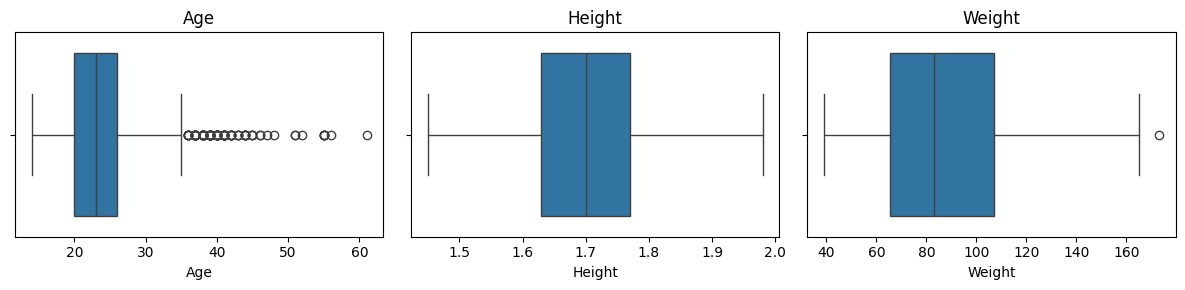


 Boxplots of Continuous Data after Fixing Outliers:


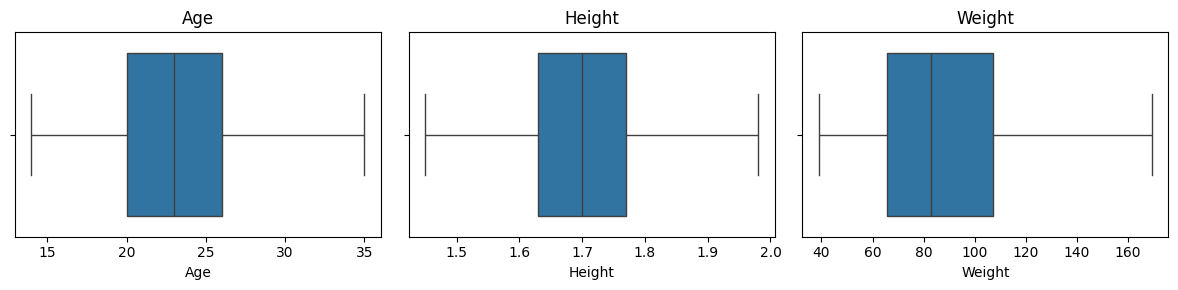



The dimension of X_train is (1477, 3)
The dimension of X_test is (634, 3)



 -------------------- KNN CLASSIFIER --------------------

Best Parameters: {'n_neighbors': 18, 'weights': 'distance'}


The train score for the best KNN model is 1.0
The test score for the best KNN model is 0.8501577287066246

Classification Report Using KNN:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       477
           1       0.74      0.61      0.67       157

    accuracy                           0.85       634
   macro avg       0.81      0.77      0.79       634
weighted avg       0.84      0.85      0.85       634

Confusion Matrix:
 [[443  34]
 [ 61  96]]



 -------------------- SUPPORT VECTOR MACHINE --------------------

Best Parameters: {'C': 15, 'gamma': 'scale', 'kernel': 'poly'}


The train score for the best KNN model is 0.7603249830737983
The test score for the best KNN model is 0.7823343848580442

Classification Report Using SVM:
 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 


Best Parameters: {'C': 15, 'penalty': 'l2', 'solver': 'liblinear'}


The train score for the best KNN model is 0.7752200406228842
The test score for the best KNN model is 0.7902208201892744

Classification Report Using Logistic Regression:
              precision    recall  f1-score   support

           0       0.79      0.97      0.87       477
           1       0.74      0.24      0.36       157

    accuracy                           0.79       634
   macro avg       0.77      0.60      0.62       634
weighted avg       0.78      0.79      0.75       634

Confusion Matrix:
 [[464  13]
 [120  37]]



 -------------------- DECISION TREE CLASSIFIER --------------------

Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2}


The train score for the best KNN model is 0.9248476641841571
The test score for the best KNN model is 0.8186119873817035

Classification Report Using Decision Tree Classifier:
              precision    recall  f1-score   support

  

In [ ]:
weight_main()

### One Class Learning

In [ ]:
def oneclass_main():
  df, continuous, categorical, target = data_preprocessing()
  X, y = data_processing(df, continuous, categorical, target)

  X_majority = X[y == 0]
  X_minority = X[y == 1]

  print("Number of majority class samples:", len(X_majority))
  print("Number of minority class samples:", len(X_minority))



  # LOCAL OUTLIER FACTOR (UNDERLYING KNN)
  print("\n\n\n -------------------- LOCAL OUTLIER FACTOR (UNDERLYING KNN) --------------------")
  # Fit the Local Outlier Factor model to the majority class
  lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
  y_pred_lof = lof.fit_predict(X)

  # Convert -1 to 1 (minority) and 1 to 0 (majority) for compatibility with y
  y_pred_lof = np.where(y_pred_lof == 1, 0, 1)

  print("\nClassification Report for Local Outlier Factor:")
  print(classification_report(y, y_pred_lof))

  cm = confusion_matrix(y, y_pred_lof)
  print("Confusion Matrix:\n", cm)



  # ONE-CLASS SVM (UNDERLYING SVM)
  print("\n\n\n -------------------- ONE-CLASS SVM (UNDERLYING SVM) --------------------")
  # Fit the One-Class SVM model to the majority class
  oc_svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)
  oc_svm.fit(X_majority)

  # Predict on the entire dataset
  y_pred_svm = oc_svm.predict(X)

  # -1 indicates an outlier, 1 indicates an inlier
  # Convert -1 to 1 (minority) and 1 to 0 (majority) for compatibility with y
  y_pred_svm = np.where(y_pred_svm == 1, 0, 1)

  print("\nClassification Report for One-Class SVM:")
  print(classification_report(y, y_pred_svm))

  cm = confusion_matrix(y, y_pred_svm)
  print("Confusion Matrix:\n", cm)



  # ISOLATION FOREST (UNDERLYING RANDOM FOREST)
  print("\n\n\n -------------------- ISOLATION FOREST (UNDERLYING RANDOM FOREST) --------------------")
  # Fit the Isolation Forest model to the majority class
  iso_forest = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.05, random_state=42)
  iso_forest.fit(X_majority)

  # Predict on the entire dataset
  y_pred_iso = iso_forest.predict(X)

  # -1 indicates an outlier, 1 indicates an inlier
  # Convert -1 to 1 (minority) and 1 to 0 (majority) for compatibility with y
  y_pred_iso = np.where(y_pred_iso == 1, 0, 1)

  print("\nClassification Report for Isolation Forest Model:")
  print(classification_report(y, y_pred_iso))

  cm = confusion_matrix(y, y_pred_iso)
  print("Confusion Matrix:\n", cm)



 Boxplots of Continuous Data before Pre-Processing:


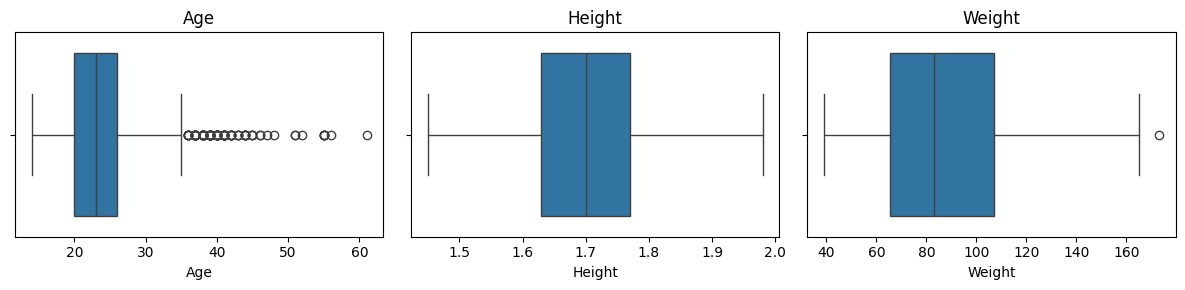


 Boxplots of Continuous Data after Fixing Outliers:


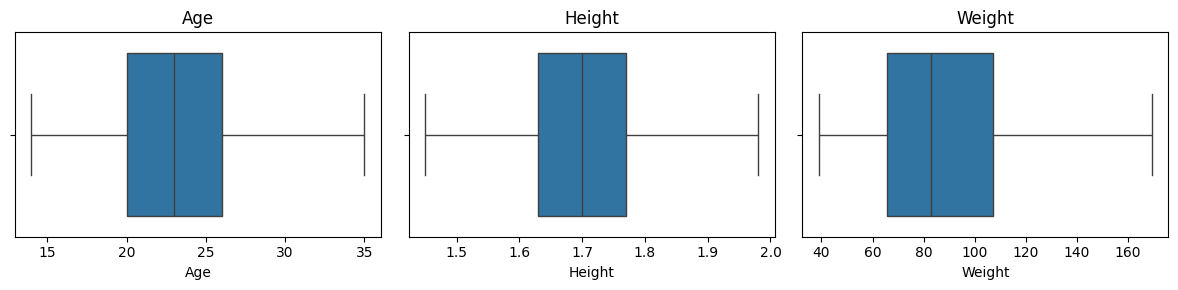



Number of majority class samples: 1552
Number of minority class samples: 559



 -------------------- LOCAL OUTLIER FACTOR (UNDERLYING KNN) --------------------

Classification Report for Local Outlier Factor:
              precision    recall  f1-score   support

           0       0.73      0.94      0.82      1552
           1       0.14      0.03      0.05       559

    accuracy                           0.70      2111
   macro avg       0.44      0.48      0.43      2111
weighted avg       0.57      0.70      0.62      2111

Confusion Matrix:
 [[1461   91]
 [ 544   15]]



 -------------------- ONE-CLASS SVM (UNDERLYING SVM) --------------------

Classification Report for One-Class SVM:
              precision    recall  f1-score   support

           0       0.78      0.95      0.85      1552
           1       0.62      0.24      0.35       559

    accuracy                           0.76      2111
   macro avg       0.70      0.59      0.60      2111
weighted avg       0.74 

In [ ]:
oneclass_main()